# Unsupervised Algorithms in Machine Learning Final Project - Week 5
### How dimensionality reduction improves clustering performance?
### Aaron Li

In this project we will build on some unsupervised learning concepts by implementing clustering, which attempts to group objects together based on similarity. With unsupervised models, clustering achieves this without using any labels. MNIST (Mixed National Institute of Standards and Technology) database of handwritten digits will be used for the exercises.

### Import necessary libraries

In [1]:
# Basics
import numpy as np
import pandas as pd
import os, time
import pickle, gzip

# Data visualization
import matplotlib.pyplot as plt
import matplotlib as mpl
import seaborn as sns
color = sns.color_palette()
%matplotlib inline

# EDA and metrics
from sklearn import preprocessing as pp
from sklearn.model_selection import train_test_split 
from sklearn.metrics import precision_recall_curve, average_precision_score
from sklearn.metrics import roc_curve, auc, roc_auc_score

# Algorithms
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans

### Load Data from pickle package and separate them into Train, Validation and Test datasets

In [2]:
# Load mnist data from pickle package
current_path = os.getcwd()
file = os.path.sep.join(['', 'data', 'mnist.pkl.gz'])

f = gzip.open(current_path+file, 'rb')
train_set, validation_set, test_set = pickle.load(f, encoding='latin1')
f.close()

X_train, y_train = train_set[0], train_set[1]
X_validation, y_validation = validation_set[0], validation_set[1]
X_test, y_test = test_set[0], test_set[1]

In [3]:
# Load datasets into Pandas dataframes
train_index = range(0,len(X_train))
validation_index = range(len(X_train), \
                         len(X_train)+len(X_validation))
test_index = range(len(X_train)+len(X_validation), \
                   len(X_train)+len(X_validation)+len(X_test))

X_train = pd.DataFrame(data=X_train,index=train_index)
y_train = pd.Series(data=y_train,index=train_index)

X_validation = pd.DataFrame(data=X_validation,index=validation_index)
y_validation = pd.Series(data=y_validation,index=validation_index)

X_test = pd.DataFrame(data=X_test,index=test_index)
y_test = pd.Series(data=y_test,index=test_index)

print("X_train.shape:",X_train.shape, "y_train.shape:",y_train.shape)
print("X_validation.shape:",X_validation.shape, "y_validation.shape:",y_validation.shape)
print("X_test.shape:",X_test.shape, "y_test.shape:",y_test.shape)

X_train.shape: (50000, 784) y_train.shape: (50000,)
X_validation.shape: (10000, 784) y_validation.shape: (10000,)
X_test.shape: (10000, 784) y_test.shape: (10000,)


In [4]:
X_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50000 entries, 0 to 49999
Columns: 784 entries, 0 to 783
dtypes: float32(784)
memory usage: 149.5 MB


In [5]:
y_train.info()

<class 'pandas.core.series.Series'>
RangeIndex: 50000 entries, 0 to 49999
Series name: None
Non-Null Count  Dtype
--------------  -----
50000 non-null  int64
dtypes: int64(1)
memory usage: 390.8 KB


This dataset has been divided into three sets—a training set with 50,000 examples, a validation set with 10,000 examples, and a test set with 10,000 examples. We have labels for all the examples.

This dataset consists of 28x28 pixel images of handwritten digits. Every single data point (i.e., every image) can be conveyed as an array of numbers, where each number describes how dark each pixel is. In other words, a 28x28 array of numbers corresponds to a 28x28 pixel image.

To make this simpler, we can flatten each array into a 28x28, or 784, dimensional vector. Each component of the vector is a float between zero and one—representing the intensity of each pixel in the image. Zero stands for black; one stands for white. The labels are numbers between zero and nine, and indicate which digit the image represents.

In [6]:
X_train.head().iloc[:, 120:136]

,120,121,122,123,124,125,126,127,128,129,130,131,132,133,134,135
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.199219,0.621094,0.988281,0.621094,0.195312,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0


### PCA Dimensionality Reduction
We are not reducing the dimensionality below, but will change the number of the components in later sections.

In [7]:
# Principal Component Analysis
from sklearn.decomposition import PCA

n_components = 784
whiten = False
random_state = 2022

# Whitening will remove some information from the transformed signal (the relative variance scales of the components) but can sometime improve the predictive accuracy of the downstream estimators by making their data respect some hard-wired assumptions.
pca = PCA(n_components=n_components, whiten=whiten, \
          random_state=random_state)

X_train_PCA = pca.fit_transform(X_train)
X_train_PCA = pd.DataFrame(data=X_train_PCA, index=train_index)
print("X_train_PCA.shape:",X_train_PCA.shape)

X_train_PCA.shape: (50000, 784)


### Clustering - K-means

The objective of clustering is to identify distinct groups in a dataset such that the observations within a group are similar to each other but different from observations in other groups. In k-means clustering, we specify the number of desired clusters k, and the algorithm will assign each observation to exactly one of these k clusters. We will keep the default values for number of initializations (10), maximum number of iterations (300), and tolerance (0.0001).
For now, we will use the first 100 principal components from PCA. To test how the number of clusters we designate affects the inertia measure, let’s run k-means for cluster sizes 2 through 20 and record the inertia for each.

In [8]:
# K-means - Inertia as the number of clusters varies
from sklearn.cluster import KMeans

n_clusters = 10
n_init = 10
max_iter = 300
tol = 0.0001

kMeans_inertia = pd.DataFrame(data=[],index=range(2,21), \
                              columns=['inertia'])
for n_clusters in range(2,21):
    kmeans = KMeans(n_clusters=n_clusters, n_init=n_init, \
                max_iter=max_iter, tol=tol, random_state=random_state)

    cutoff = 99
    kmeans.fit(X_train_PCA.loc[:,0:cutoff])
    kMeans_inertia.loc[n_clusters] = kmeans.inertia_

<AxesSubplot:>

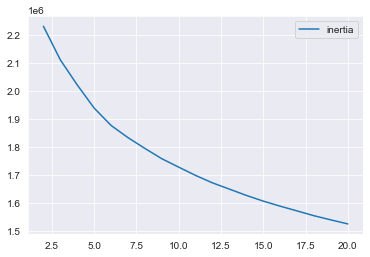

In [9]:
# Plot inertia relative to k # of clusters
kMeans_inertia.plot()

The inertia decreases as the number of clusters increases. This makes sense. The more clusters we have, the greater the homogeneity among observations within each cluster. However, fewer clusters are easier to work with than more, so finding the right number of clusters to generate is an important consideration when running k-means.

### Accuracy analysis
Let’s define a function to analyze the results of each experiment we do. The cluster assignments—generated by the clustering algorithm—will be stored in a Pandas DataFrame called clusterDF.

In [10]:
# Define analyze cluster function
def analyzeCluster(clusterDF, labelsDF):
    countByCluster = \
        pd.DataFrame(data=clusterDF['cluster'].value_counts())
    countByCluster.reset_index(inplace=True,drop=False)
    countByCluster.columns = ['cluster','clusterCount']
        
    preds = pd.concat([labelsDF,clusterDF], axis=1)
    preds.columns = ['trueLabel','cluster']
    
    countByLabel = pd.DataFrame(data=preds.groupby('trueLabel').count())
        
    countMostFreq = \
        pd.DataFrame(data=preds.groupby('cluster').agg( \
                        lambda x:x.value_counts().iloc[0]))
    countMostFreq.reset_index(inplace=True,drop=False)
    countMostFreq.columns = ['cluster','countMostFrequent']
    
    accuracyDF = countMostFreq.merge(countByCluster, \
                        left_on="cluster",right_on="cluster")
    overallAccuracy = accuracyDF.countMostFrequent.sum()/ \
                        accuracyDF.clusterCount.sum()
    
    accuracyByLabel = accuracyDF.countMostFrequent/ \
                        accuracyDF.clusterCount
    
    return countByCluster, countByLabel, countMostFreq, \
            accuracyDF, overallAccuracy, accuracyByLabel

### Accuracy as number of clusters varies
Instead of calculating inertia, we will calculate the overall homogeneity of the clusters based on the accuracy measure we’ve defined for this MNIST digits dataset:

In [11]:
# K-means - Accuracy as the number of clusters varies

n_clusters = 5
n_init = 10
max_iter = 300
tol = 0.0001

kMeans_inertia = \
    pd.DataFrame(data=[],index=range(2,21),columns=['inertia'])
overallAccuracy_kMeansDF = \
    pd.DataFrame(data=[],index=range(2,21),columns=['overallAccuracy'])

for n_clusters in range(2,21):
    kmeans = KMeans(n_clusters=n_clusters, n_init=n_init, \
                max_iter=max_iter, tol=tol, random_state=random_state)

    cutoff = 99
    kmeans.fit(X_train_PCA.loc[:,0:cutoff])
    kMeans_inertia.loc[n_clusters] = kmeans.inertia_
    X_train_kmeansClustered = kmeans.predict(X_train_PCA.loc[:,0:cutoff])
    X_train_kmeansClustered = \
        pd.DataFrame(data=X_train_kmeansClustered, index=X_train.index, \
                     columns=['cluster'])
    
    countByCluster_kMeans, countByLabel_kMeans, countMostFreq_kMeans, \
        accuracyDF_kMeans, overallAccuracy_kMeans, accuracyByLabel_kMeans \
        = analyzeCluster(X_train_kmeansClustered, y_train)
    
    overallAccuracy_kMeansDF.loc[n_clusters] = overallAccuracy_kMeans

<AxesSubplot:>

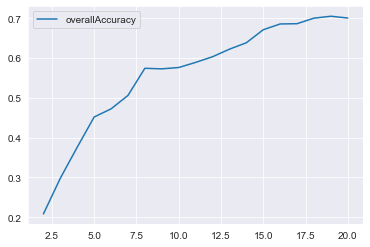

In [12]:
# Plot accuracy
overallAccuracy_kMeansDF.plot()

The accuracy improves as the number of clusters increases. In other words, clusters become more homogeneous as we increase the number of clusters because each cluster becomes smaller and more tightly formed.
In some clusters, over 90% of the images have the same digit; in other clusters, less than 50% of the images have the same digit:

In [13]:
# Accuracy by cluster
accuracyByLabel_kMeans

0     0.456813
1     0.944000
2     0.635368
3     0.500539
4     0.928738
5     0.956995
6     0.380699
7     0.402020
8     0.873449
9     0.849296
10    0.587969
11    0.520331
12    0.889807
13    0.932331
14    0.843784
15    0.780171
16    0.916667
17    0.710207
18    0.461870
19    0.951499
dtype: float64

Let's take a look at predicted clusters for train dataset:

In [14]:
# View cluster labels
X_train_kmeansClustered

,cluster
0,17
1,13
2,0
3,9
4,6
...,...
49995,3
49996,5
49997,7
49998,18


## Accuracy as the number of principal components changes
If PCA does a good job of capturing the underlying structure in the data as compactly as possible, the clustering should perform just as well using 10 or 50 principal components as it does using one hundred or several hundred principal components.

In [15]:
# K-means - Accuracy as the number of components varies

n_clusters = 20
n_init = 10
max_iter = 300
tol = 0.0001

kMeans_inertia = pd.DataFrame(data=[],index=[9, 49, 99, 199, \
                    299, 399, 499, 599, 699, 783],columns=['inertia'])

overallAccuracy_kMeansDF = pd.DataFrame(data=[],index=[9, 49, \
                    99, 199, 299, 399, 499, 599, 699, 783], \
                    columns=['overallAccuracy'])

for cutoffNumber in [9, 49, 99, 199, 299, 399, 499, 599, 699, 783]:
    kmeans = KMeans(n_clusters=n_clusters, n_init=n_init, \
                max_iter=max_iter, tol=tol, random_state=random_state)

    cutoff = cutoffNumber
    kmeans.fit(X_train_PCA.loc[:,0:cutoff])
    kMeans_inertia.loc[cutoff] = kmeans.inertia_
    X_train_kmeansClustered = kmeans.predict(X_train_PCA.loc[:,0:cutoff])
    X_train_kmeansClustered = pd.DataFrame(data=X_train_kmeansClustered, \
                                index=X_train.index, columns=['cluster'])
    
    countByCluster_kMeans, countByLabel_kMeans, countMostFreq_kMeans, \
        accuracyDF_kMeans, overallAccuracy_kMeans, accuracyByLabel_kMeans \
        = analyzeCluster(X_train_kmeansClustered, y_train)
    
    overallAccuracy_kMeansDF.loc[cutoff] = overallAccuracy_kMeans

<AxesSubplot:>

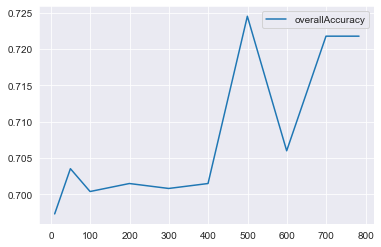

In [16]:
# Accuracy relative to number of principal components
overallAccuracy_kMeansDF.plot()

As the number of principal components varies from 10 to 784, the clustering accuracy remains stable and consistent around 70%. This is one reason why clustering should be performed on dimensionality-reduced datasets — the clustering algorithms generally perform better, both in terms of time and clustering accuracy, on dimensionality-reduced datasets.

## Accuracy as the number of original dimensions changes
For the PCA-reduced dataset in the previous section, varying the number of principal components that we passed into the clustering algorithm did not affect the clustering accuracy, which remained stable and consistent at approximately 70%. Lets see if this still remains true with changing the dimension of the original dataset.

In [17]:
# K-means - Accuracy as the number of components varies
# On the original MNIST data (not PCA-reduced)

n_clusters = 20
n_init = 10
max_iter = 300
tol = 0.0001

kMeans_inertia = pd.DataFrame(data=[],index=[9, 49, 99, 199, \
                    299, 399, 499, 599, 699, 783],columns=['inertia'])

overallAccuracy_kMeansDF = pd.DataFrame(data=[],index=[9, 49, \
                    99, 199, 299, 399, 499, 599, 699, 783], \
                    columns=['overallAccuracy'])

#Pass along 10, 50, 100, 200, 300, 400, 500, 600, 700, and 784 principal components and gauge the accuracy of each clustering experiment.
for cutoffNumber in [9, 49, 99, 199, 299, 399, 499, 599, 699, 783]:
    kmeans = KMeans(n_clusters=n_clusters, n_init=n_init, \
                max_iter=max_iter, tol=tol, random_state=random_state)

    cutoff = cutoffNumber
    kmeans.fit(X_train.loc[:,0:cutoff])
    kMeans_inertia.loc[cutoff] = kmeans.inertia_
    X_train_kmeansClustered = kmeans.predict(X_train.loc[:,0:cutoff])
    X_train_kmeansClustered = pd.DataFrame(data=X_train_kmeansClustered, \
                                index=X_train.index, columns=['cluster'])
    
    countByCluster_kMeans, countByLabel_kMeans, countMostFreq_kMeans, \
        accuracyDF_kMeans, overallAccuracy_kMeans, accuracyByLabel_kMeans \
        = analyzeCluster(X_train_kmeansClustered, y_train)
    
    overallAccuracy_kMeansDF.loc[cutoff] = overallAccuracy_kMeans

/var/folders/2d/39qb0j_s3jvg__n_84m644fc0000gn/T/ipykernel_17468/3854451747.py:22: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (20). Possibly due to duplicate points in X.
  kmeans.fit(X_train.loc[:,0:cutoff])


<AxesSubplot:>

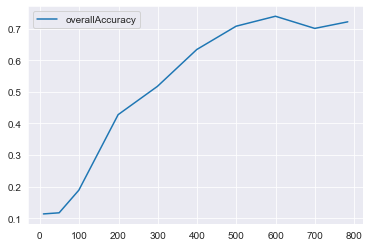

In [18]:
# Accuracy relative to number of original dimensions
overallAccuracy_kMeansDF.plot()

As the plot shows, clustering accuracy is very poor at lower dimensions but improves to nearly 70% only as the number of dimensions climbs to six hundred dimensions.
In the PCA case, clustering accuracy was approximately 70% even at 10 dimensions, demonstrating the power of dimensionality reduction to densely capture salient information in the original dataset.

### Conclusion
As above test cases prove, clustering should always be performed on dimensionality-reduced datasets, as outcome of the clustering will generally look
 better, both in terms of time and clustering accuracy, on dimensionality-reduced datasets.